In [1]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 3.1 MB 13.5 MB/s 
     |████████████████████████████████| 290 kB 39.9 MB/s 
     |████████████████████████████████| 3.3 MB 33.5 MB/s 
     |████████████████████████████████| 596 kB 28.7 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
     |████████████████████████████████| 59 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 41.5 MB/s 
     |████████████████████████████████| 132 kB 45.0 MB/s 
     |████████████████████████████████| 243 kB 46.3 MB/s 
     |████████████████████████████████| 271 kB 46.6 MB/s 
     |████████████████████████████████| 192 kB 46.4 MB/s 
     |████████████████████████████████| 160 kB 49.7 MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [8]:
emotion_dataset["train"]["label"][0]

0

In [9]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [11]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [12]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [15]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [16]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [17]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text, 
            max_length=self.max_length, 
            padding="max_length", 
            return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"].squeeze(), 
            "mask": tokenizer_output["attention_mask"].squeeze(),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [18]:
train_dataset = TweetDataset("train")
valid_dataset =  TweetDataset("validation") # validation
test_dataset =  TweetDataset("test")

In [19]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [20]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [21]:
lr = 5e-4 #1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [22]:
tokens = test_dataset[0]["input_ids"].unsqueeze(0).to(device) # Получи токены из датасета
mask = test_dataset[0]["mask"].unsqueeze(0).to(device) # Получи маску из датасета

model_0(tokens, attention_mask=mask) # Посмотри на аутпут

SequenceClassifierOutputWithPast([('logits',
                                   tensor([[-0.2229, -0.4149, -0.1558,  0.3805,  0.2409, -0.3299]],
                                          device='cuda:0', grad_fn=<IndexBackward0>)),
                                  ('past_key_values',
                                   ((tensor([[[[-0.1845, -0.6131,  0.1902,  ..., -0.2858, -0.7240,  0.3391],
                                               [ 0.0414,  0.0234,  0.4125,  ..., -0.2674,  1.3003, -0.3317],
                                               [ 0.1898,  0.4834, -0.0561,  ...,  0.4078,  0.0700,  0.2244],
                                               ...,
                                               [-0.2523, -0.1946,  0.7103,  ...,  0.9268,  0.6122,  0.1636],
                                               [-0.2634, -0.2930, -0.2161,  ...,  1.2153,  0.8269, -0.3690],
                                               [-0.4068, -0.5779, -0.6767,  ...,  0.2972,  0.0464, -0.6631]],
       

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [23]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        
        input = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        optimizer.zero_grad()

        logits = model_0(input, attention_mask=mask).logits

        loss = criterion(logits, target)
        loss.backward()

        optimizer.step()

        train_loss += loss
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:

            input = batch["input_ids"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)

            logits = model_0(input.to(device), attention_mask=mask).logits

            loss = criterion(logits, target)

            valid_loss += loss
            valid_acc += (logits.argmax(-1) == target).float().mean()

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        input = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        logits = model_0(input.to(device), attention_mask=mask).logits

        test_acc += (logits.argmax(-1) == target).float().mean()
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.6951669454574585,Valid Loss: 1.4514714479446411,Valid Acc: 0.4833984375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.711889922618866,Valid Loss: 0.33354535698890686,Valid Acc: 0.88720703125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.26025739312171936,Valid Loss: 0.30378204584121704,Valid Acc: 0.8876953125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.19103415310382843,Valid Loss: 0.30928221344947815,Valid Acc: 0.88232421875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1761932522058487,Valid Loss: 0.3200608491897583,Valid Acc: 0.88671875
Test Acc: 0.87255859375


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [24]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [25]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [26]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

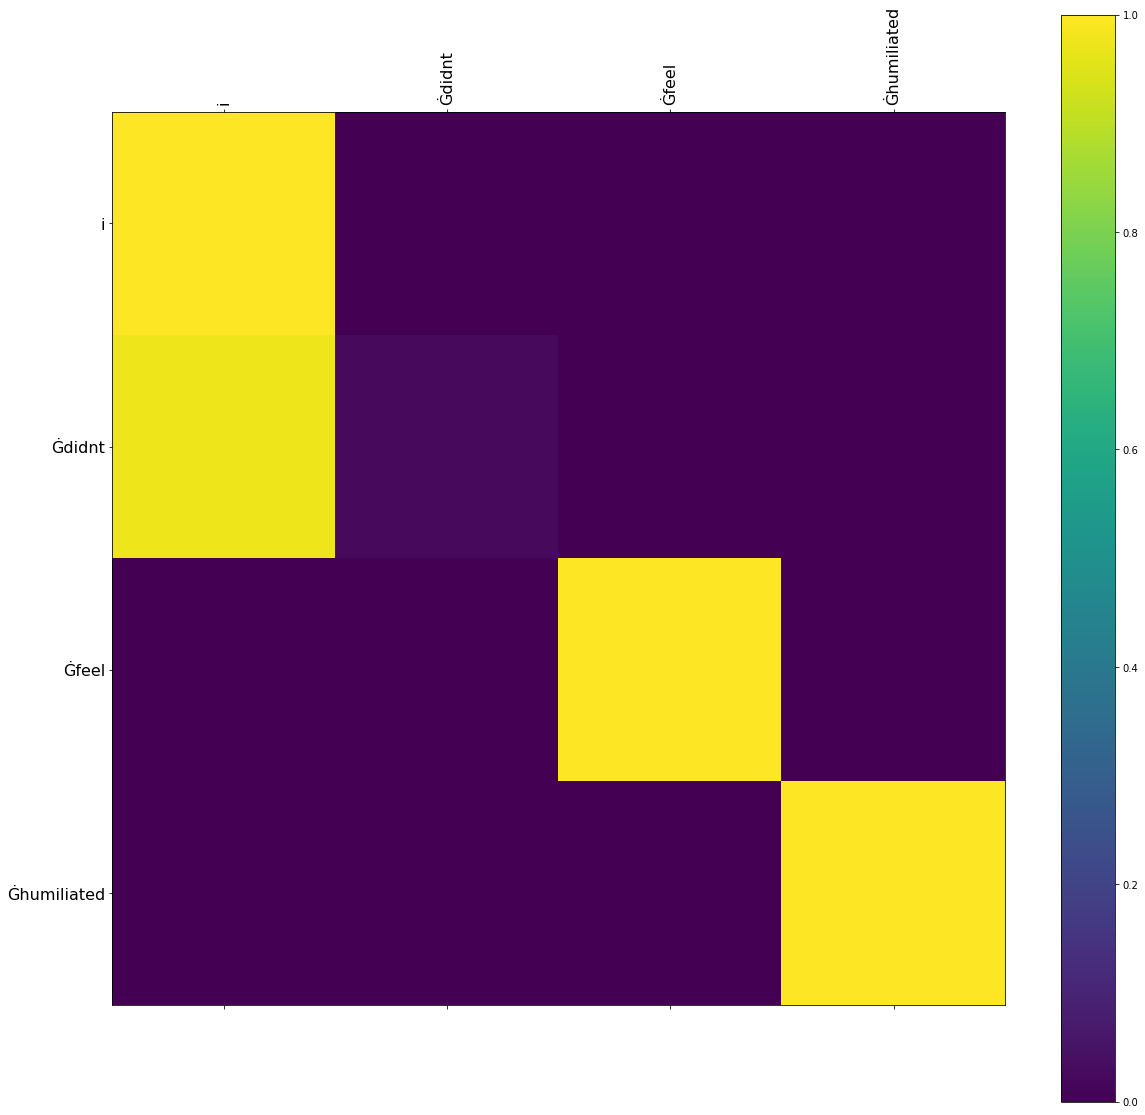

In [27]:
attn = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attn[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [28]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
lr = 5e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [30]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        
        input = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        optimizer.zero_grad()

        logits = model_1(input, attention_mask=mask).logits

        loss = criterion(logits, target)
        loss.backward()

        optimizer.step()

        train_loss += loss
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            input = batch["input_ids"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)

            logits = model_1(input.to(device), attention_mask=mask).logits

            loss = criterion(logits, target)

            valid_loss += loss
            valid_acc += (logits.argmax(-1) == target).float().mean()

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        input = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        logits = model_1(input.to(device), attention_mask=mask).logits

        test_acc += (logits.argmax(-1) == target).float().mean()
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5508331060409546,Valid Loss: 0.18022273480892181,Valid Acc: 0.9345703125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.13925807178020477,Valid Loss: 0.1387687474489212,Valid Acc: 0.9306640625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.11325464397668839,Valid Loss: 0.13424821197986603,Valid Acc: 0.93603515625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.09542784094810486,Valid Loss: 0.1509544551372528,Valid Acc: 0.9326171875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.08092335611581802,Valid Loss: 0.23879586160182953,Valid Acc: 0.92236328125
Test Acc: 0.92333984375


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [31]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

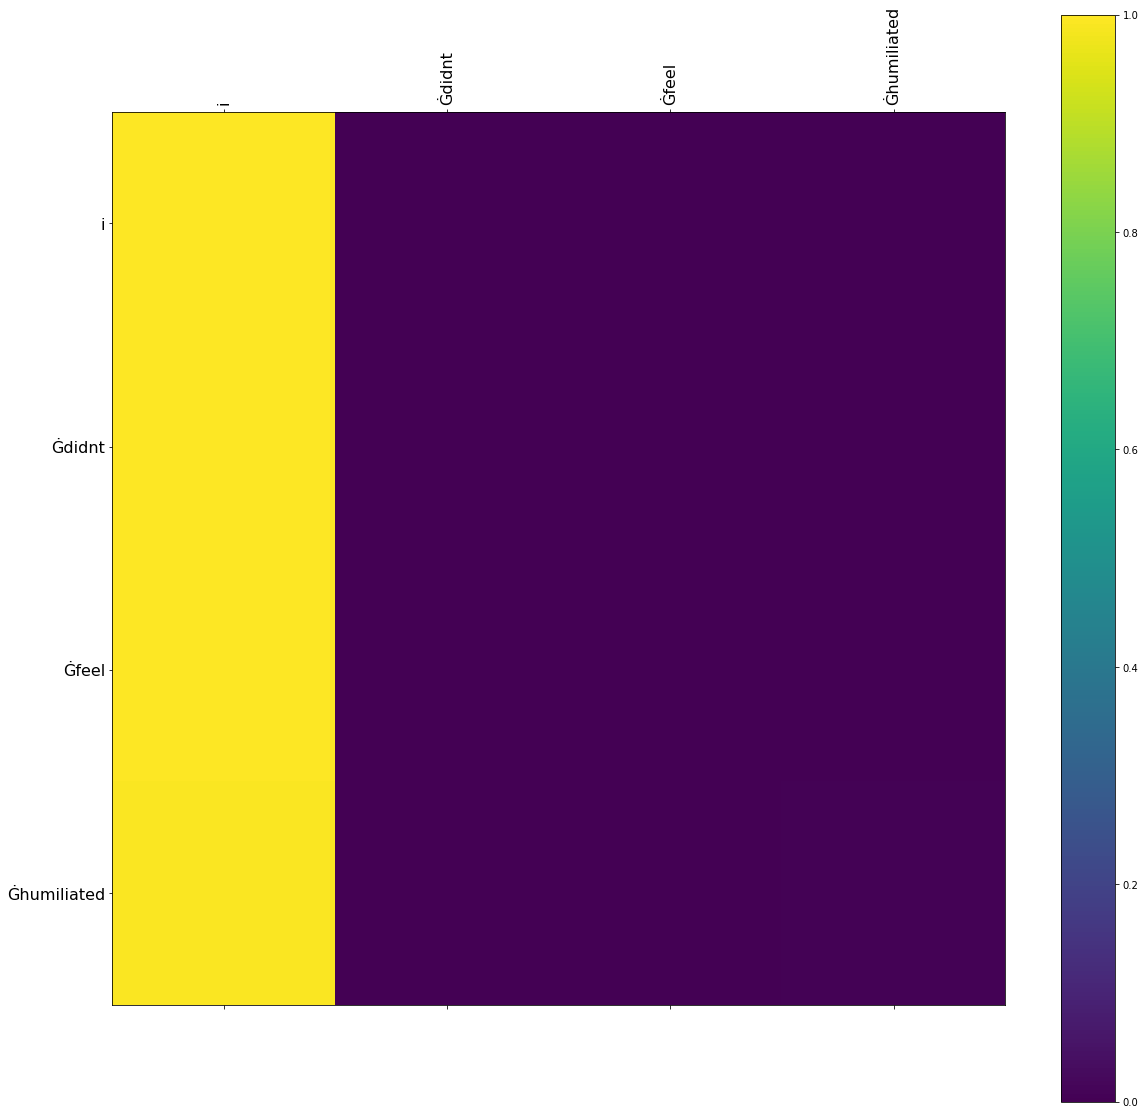

In [36]:
attn = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attn[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?
___
При обучении с нуля accuracy = 0.87, при использовании модели, которая обучалась на эту задачу accuracy = 0.92.

Прироста в скорости обучения при fine-tuning не обнаружено.

Анализируя куда смотрели токены в моделях (последний слой, первая голова), видим, что в baseline модели токены смотрят преимущественно на себя, а в предобученной модели токены смотрят на первое слово.